In [9]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime

In [218]:
# loading data and combining train data
train_df = pd.read_csv("X_train.csv", index_col=0, parse_dates=["Application.Deadline"])
y_train_df = pd.read_csv("y_train.csv", index_col=0)
train_df["HappyScore"] = y_train_df.to_numpy().flatten()
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 182 entries, 45 to 151
Data columns (total 25 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   ADMrate               179 non-null    float64       
 1   Ownership             182 non-null    object        
 2   Citytype              182 non-null    object        
 3   SAT                   143 non-null    float64       
 4   AvgCost               180 non-null    float64       
 5   Major_agriculture     182 non-null    int64         
 6   Major_NatureResource  182 non-null    int64         
 7   Major_Architecture    182 non-null    int64         
 8   Major_CS              182 non-null    int64         
 9   Major_Edu             182 non-null    int64         
 10  Major_Engineering     182 non-null    int64         
 11  Major_Bio             182 non-null    int64         
 12  Major_MathStat        182 non-null    int64         
 13  Major_Psychology      18

C:\Users\semic\AppData\Local\Temp\ipykernel_17652\1326166865.py:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  train_df = pd.read_csv("X_train.csv", index_col=0, parse_dates=["Application.Deadline"])


In [219]:
# dropping rows without ADMrate because there are only three rows missing
train_df.dropna(subset=["ADMrate"], inplace=True)

# drop unreasonable ADM rates
train_df = train_df[train_df["ADMrate"] <= 1]

In [220]:
# examining data
train_df.head(3)

,ADMrate,Ownership,Citytype,SAT,AvgCost,Major_agriculture,Major_NatureResource,Major_Architecture,Major_CS,Major_Edu,...,Major_Business,Major_History,Earn,CrimeRate,ACT,Enrollment,FBI.TotalCrime,FBI.CrimeRate,Application.Deadline,HappyScore
45,0.3072,Private nonprofit,Town,1317.0,61060.0,0,1,0,1,1,...,1,1,63800,314.1,30.0,3528.0,176,5.47,2019-01-15,49.98
8,0.2391,Private nonprofit,City,NaN,62849.0,0,1,0,1,0,...,0,1,46500,236.9,NaN,2907.0,1580,3.37,2019-01-01,57.04
55,0.1425,Private nonprofit,Suburb,1500.0,63860.0,0,0,0,1,0,...,0,0,82100,396.1,34.0,802.0,10598,6.86,2019-01-01,59.96


In [221]:
# function for composite score column
def higher_if_exists(x, y):
    return max(x, y) if x and y else np.NaN

# function to transform x data
def basic_transform(df):
    # replacing privacy suppressed with NaN
    df.loc[df["Earn"] == "PrivacySuppressed", "Earn"] = np.NaN
    df["Earn"] = df["Earn"].astype(float)
    df.dropna(subset=["Earn"], inplace=True)

    # using one-hot encoding on categorical features
    df = pd.get_dummies(df, columns=["Ownership", "Citytype"], dtype=int)

    # converting application deadline dates to days since earliest deadline
    df["Application.Deadline"] = (df["Application.Deadline"] - df["Application.Deadline"].min()).dt.days

    # replacing SAT and ACT scores with their z-scores based on test mean and standard deviation
    # and then using the higher score
    df["SAT"] = (df["SAT"] - 1024) / 229
    df["ACT"] = (df["ACT"] - 19) / 7.1
    df["composite_test_score"] = list(map(higher_if_exists, df["SAT"], df["ACT"]))
    
    # act mean: 19, std: 7.1, sat mean: 1024, std: 229
    return df

In [222]:
train_df.head(2)

,ADMrate,Ownership,Citytype,SAT,AvgCost,Major_agriculture,Major_NatureResource,Major_Architecture,Major_CS,Major_Edu,...,Major_Business,Major_History,Earn,CrimeRate,ACT,Enrollment,FBI.TotalCrime,FBI.CrimeRate,Application.Deadline,HappyScore
45,0.3072,Private nonprofit,Town,1317.0,61060.0,0,1,0,1,1,...,1,1,63800,314.1,30.0,3528.0,176,5.47,2019-01-15,49.98
8,0.2391,Private nonprofit,City,NaN,62849.0,0,1,0,1,0,...,0,1,46500,236.9,NaN,2907.0,1580,3.37,2019-01-01,57.04


In [223]:
# new df with basic transformation
bt_train_df = basic_transform(train_df)

In [224]:
bt_train_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 177 entries, 45 to 151
Data columns (total 30 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   ADMrate                      177 non-null    float64
 1   SAT                          141 non-null    float64
 2   AvgCost                      177 non-null    float64
 3   Major_agriculture            177 non-null    int64  
 4   Major_NatureResource         177 non-null    int64  
 5   Major_Architecture           177 non-null    int64  
 6   Major_CS                     177 non-null    int64  
 7   Major_Edu                    177 non-null    int64  
 8   Major_Engineering            177 non-null    int64  
 9   Major_Bio                    177 non-null    int64  
 10  Major_MathStat               177 non-null    int64  
 11  Major_Psychology             177 non-null    int64  
 12  Major_SocialScience          177 non-null    int64  
 13  Major_Business          

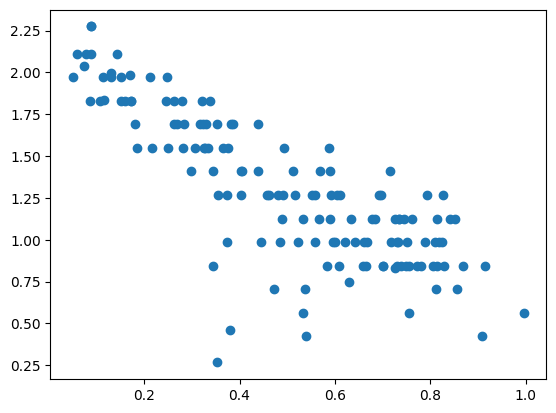

In [225]:
# missing composite test score values must be imputed
# scatter plot reveals clear linear relationship between composite score and adm rate
plt.scatter(bt_train_df["ADMrate"], bt_train_df["composite_test_score"])

In [226]:
# determing the slope and intercept of the regression line
train_indexes = bt_train_df[~bt_train_df["composite_test_score"].isna()].index

ADMrate_train = bt_train_df.loc[train_indexes, "ADMrate"].to_numpy().flatten()
composite_test_score_train = bt_train_df.loc[train_indexes, "composite_test_score"].to_numpy().flatten()

m, b = np.polyfit(ADMrate_train, composite_test_score_train, 1)

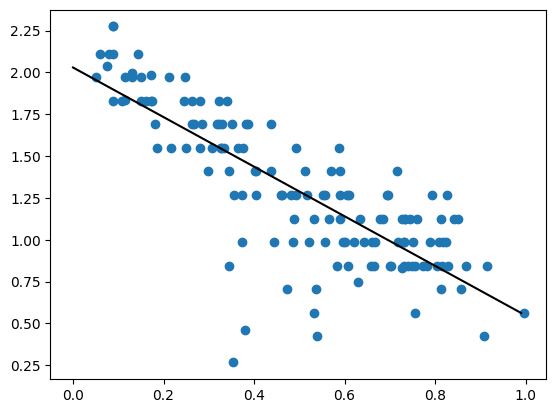

In [227]:
# looks like a good fit!
ff = np.arange(0, 1.0, 0.01)
plt.scatter(bt_train_df.loc[train_indexes, "ADMrate"].to_numpy().reshape(-1, 1), bt_train_df.loc[train_indexes, "composite_test_score"].to_numpy().reshape(-1, 1))
plt.plot(ff, [m * x + b for x in ff], color = "black")
plt.show()

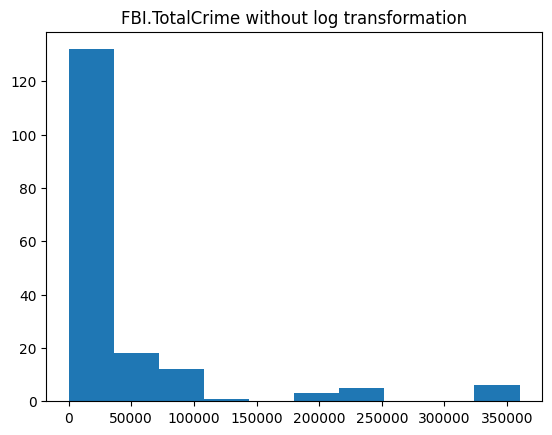

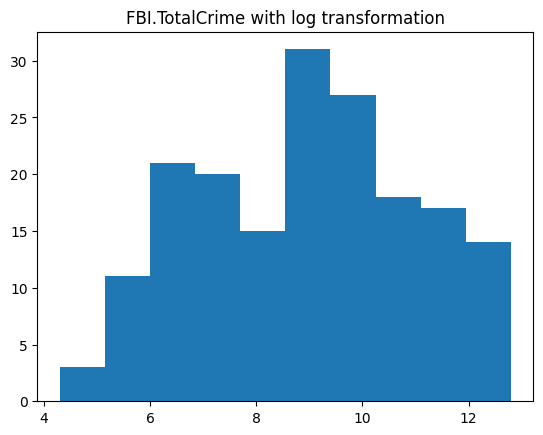

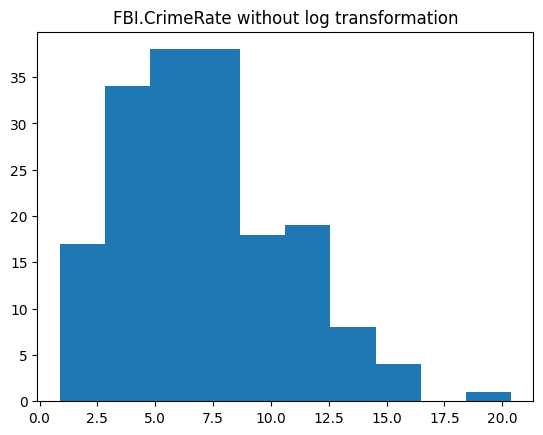

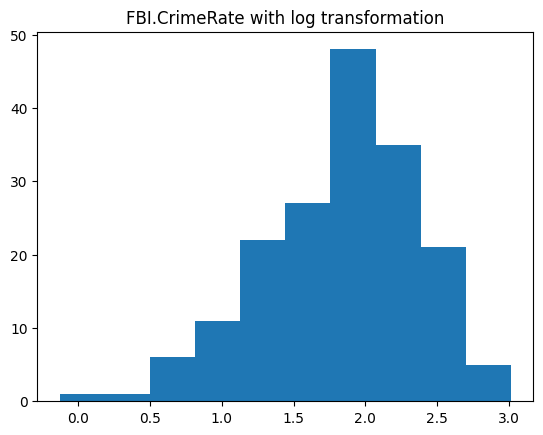

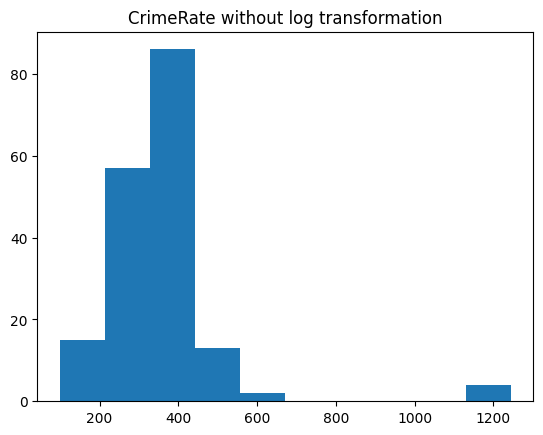

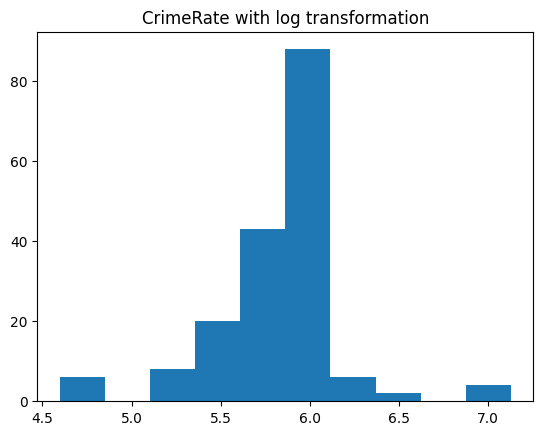

In [232]:
# additionally, the crime data are heavily right skewed but this can be fixed using a log transformation

plt.hist(train_df["FBI.TotalCrime"])
plt.title("FBI.TotalCrime without log transformation")
plt.show()

plt.hist(np.log(train_df["FBI.TotalCrime"]))
plt.title("FBI.TotalCrime with log transformation")
plt.show()

plt.hist(train_df["FBI.CrimeRate"])
plt.title("FBI.CrimeRate without log transformation")
plt.show()

plt.hist(np.log(train_df["FBI.CrimeRate"]))
plt.title("FBI.CrimeRate with log transformation")
plt.show()

plt.hist(train_df["CrimeRate"])
plt.title("CrimeRate without log transformation")
plt.show()

plt.hist(np.log(train_df["CrimeRate"]))
plt.title("CrimeRate with log transformation")
plt.show()

In [233]:
from sklearn.preprocessing import StandardScaler

# new advanced function to normalize everything and impute missing composite score values with previous linear regression model
def normalize_and_impute(df, adm_scaler, test_scaler, cost_scaler, earn_scaler, crime_scaler, enrollment_scaler, fbi_crime_scaler, fbi_crate_scaler, deadline_scaler, train):
    # impute missing composite test score values
    df["composite_test_score"] = df["composite_test_score"].fillna(m * df["ADMrate"] + b)

    # transform right skewed crime data
    df["FBI.TotalCrime"] = np.log(df["FBI.TotalCrime"])
    df["FBI.CrimeRate"] = np.log(df["FBI.CrimeRate"])
    df["CrimeRate"] = np.log(df["CrimeRate"])
    

    # normalize everything
    if train:
        df["ADMrate"] = adm_scaler.fit_transform(df["ADMrate"].to_numpy().reshape(-1, 1))
        df["composite_test_score"] = test_scaler.fit_transform(df["composite_test_score"].to_numpy().reshape(-1, 1))
        df["AvgCost"] = cost_scaler.fit_transform(df["AvgCost"].to_numpy().reshape(-1, 1))
        df["Earn"] = earn_scaler.fit_transform(df["Earn"].to_numpy().reshape(-1, 1))
        df["CrimeRate"] = crime_scaler.fit_transform(df["CrimeRate"].to_numpy().reshape(-1, 1))
        df["Enrollment"] = enrollment_scaler.fit_transform(df["Enrollment"].to_numpy().reshape(-1, 1))
        df["FBI.TotalCrime"] = fbi_crime_scaler.fit_transform(df["FBI.TotalCrime"].to_numpy().reshape(-1, 1))
        df["FBI.CrimeRate"] = fbi_crate_scaler.fit_transform(df["FBI.CrimeRate"].to_numpy().reshape(-1, 1))
        df["Application.Deadline"] = deadline_scaler.fit_transform(df["Application.Deadline"].to_numpy().reshape(-1, 1))
    else:
        df["ADMrate"] = adm_scaler.transform(df["ADMrate"].to_numpy().reshape(-1, 1))
        df["composite_test_score"] = test_scaler.transform(df["composite_test_score"].to_numpy().reshape(-1, 1))
        df["AvgCost"] = cost_scaler.transform(df["AvgCost"].to_numpy().reshape(-1, 1))
        df["Earn"] = earn_scaler.transform(df["Earn"].to_numpy().reshape(-1, 1))
        df["CrimeRate"] = crime_scaler.transform(df["CrimeRate"].to_numpy().reshape(-1, 1))
        df["Enrollment"] = enrollment_scaler.transform(df["Enrollment"].to_numpy().reshape(-1, 1))
        df["FBI.TotalCrime"] = fbi_crime_scaler.transform(df["FBI.TotalCrime"].to_numpy().reshape(-1, 1))
        df["FBI.CrimeRate"] = fbi_crate_scaler.transform(df["FBI.CrimeRate"].to_numpy().reshape(-1, 1))
        df["Application.Deadline"] = deadline_scaler.transform(df["Application.Deadline"].to_numpy().reshape(-1, 1))

    
    return df

In [234]:
# creating a dictionaries for scalers
scaler_dict = {}
for i in ["ADMrate", "composite_test_score", "AvgCost", "Earn", "CrimeRate", "Enrollment", "FBI.TotalCrime", "FBI.CrimeRate", "Application.Deadline"]:
    scaler_dict[i] = StandardScaler()

In [235]:
# applying normalize and impute function]
# dropping unecessary columns
final_train_df = normalize_and_impute(bt_train_df, *scaler_dict.values(), train=True)
final_train_df.drop(columns=["SAT", "ACT"], inplace=True)

In [147]:
# combining both transformation functions
def x_transform(df, adm_scaler, test_scaler, cost_scaler, earn_scaler, crime_scaler, enrollment_scaler, fbi_crime_scaler, fbi_crate_scaler, deadline_scaler, train):
    df = basic_transform(df)
    df = normalize_and_impute(df, adm_scaler, test_scaler, cost_scaler, earn_scaler, 
                              crime_scaler, enrollment_scaler, fbi_crime_scaler, fbi_crate_scaler, deadline_scaler, train)
    return df

In [236]:
# splitting training data
train = final_train_df.sample(frac=0.9, random_state=42)
test = final_train_df.drop(train.index)
X_train, y_train = train.drop("HappyScore", axis=1), train["HappyScore"]
X_test, y_test = test.drop("HappyScore", axis=1), test["HappyScore"]